# SANDBOX BRAN2020 UV
15 June 2023
Thomas Moore

In [1]:
import xarray as xr
import numpy as np

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:38699' processes=28 threads=28, memory=125.20 GiB>

In [3]:
bran_u = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_u_mth_20*',parallel=True)
bran_v = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth_20*',parallel=True)

In [4]:
bran_u

<xarray.Dataset>
Dimensions:         (Time: 276, nv: 2, xu_ocean: 3600, yu_ocean: 1500,
                     st_ocean: 51, st_edges_ocean: 52)
Coordinates:
  * xu_ocean        (xu_ocean) float64 0.1 0.2 0.3 0.4 ... 359.8 359.9 360.0
  * yu_ocean        (yu_ocean) float64 -74.9 -74.8 -74.7 ... 74.8 74.9 75.0
  * st_ocean        (st_ocean) float64 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
  * Time            (Time) datetime64[ns] 2000-01-16T12:00:00 ... 2022-12-16T...
  * nv              (nv) float64 1.0 2.0
  * st_edges_ocean  (st_edges_ocean) float64 0.0 5.0 10.0 ... 4.056e+03 5e+03
Data variables:
    average_DT      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    Time_bounds     (Time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    average_T1      (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2      (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    u               (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 51, 1500, 3600), meta=np.ndarray>
Attributes:
    filename:           TMP/ocean_ofam_2000_01_01.nc.0000
    NumFilesInSet:      20
    grid_type:          regular
    grid_tile:          N/A
    history:            Tue Mar 30 16:16:56 2021: ncap2 -O -s average_DT=aver...
    NCO:                netCDF Operators version 4.9.2 (Homepage = http://nco...
    title:              BRAN2020
    catalogue_doi_url:  http://dx.doi.org/10.25914/6009627c7af03
    acknowledgement:    BRAN is made freely available by CSIRO Bluelink and i...

In [ ]:
bran_u.u.isel({'Time':0,'st_ocean':0}).plot(robust=True)

# how big is chunking - both Dask and in NetCDF?

# subset for CARS region

In [ ]:
AUS_bran2020_U = bran_u.u.sel({'yu_ocean':slice(-50,0),'xu_ocean':slice(90,180)})
AUS_bran2020_V = bran_v.v.sel({'yu_ocean':slice(-50,0),'xu_ocean':slice(90,180)})

In [ ]:
AUS_bran2020_UV = xr.merge([AUS_bran2020_U,AUS_bran2020_V])

In [ ]:
AUS_bran2020_UV

# write to zarr collection - `/scratch/xv83/tm4888/zarr_collections`

In [ ]:
%%time
AUS_bran2020_UV.to_zarr('/scratch/xv83/tm4888/zarr_collections/BRAN2020/AUSregion.BRAN2020.month.UV.zarr',consolidated=True)

# load in zarr

In [3]:
UV = xr.open_zarr('/scratch/xv83/tm4888/zarr_collections/BRAN2020/AUSregion.BRAN2020.month.UV.zarr',consolidated=True)

In [4]:
UV

<xarray.Dataset>
Dimensions:   (Time: 276, st_ocean: 51, yu_ocean: 500, xu_ocean: 901)
Coordinates:
  * Time      (Time) datetime64[ns] 2000-01-16T12:00:00 ... 2022-12-16T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xu_ocean  (xu_ocean) float64 90.0 90.1 90.2 90.3 ... 179.7 179.8 179.9 180.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... -0.4 -0.3 -0.2 -0.1
Data variables:
    u         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 51, 500, 901), meta=np.ndarray>
    v         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 51, 500, 901), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean Time: mean
    long_name:      i-current
    packing:        4
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-32767, 32767]

In [5]:
UV_rc = UV.chunk({'Time':276,'st_ocean':1})

In [6]:
UV_rc

<xarray.Dataset>
Dimensions:   (Time: 276, st_ocean: 51, yu_ocean: 500, xu_ocean: 901)
Coordinates:
  * Time      (Time) datetime64[ns] 2000-01-16T12:00:00 ... 2022-12-16T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xu_ocean  (xu_ocean) float64 90.0 90.1 90.2 90.3 ... 179.7 179.8 179.9 180.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... -0.4 -0.3 -0.2 -0.1
Data variables:
    u         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(276, 1, 500, 901), meta=np.ndarray>
    v         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(276, 1, 500, 901), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean Time: mean
    long_name:      i-current
    packing:        4
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-32767, 32767]

In [7]:
clim_uv = UV_rc.groupby('Time.month').mean(method="cohorts", engine="flox")

In [8]:
clim_uv

<xarray.Dataset>
Dimensions:   (month: 12, st_ocean: 51, yu_ocean: 500, xu_ocean: 901)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xu_ocean  (xu_ocean) float64 90.0 90.1 90.2 90.3 ... 179.7 179.8 179.9 180.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... -0.4 -0.3 -0.2 -0.1
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u         (month, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 1, 500, 901), meta=np.ndarray>
    v         (month, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 1, 500, 901), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean Time: mean
    long_name:      i-current
    packing:        4
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-32767, 32767]

In [9]:
clim_uv.u.isel(st_ocean=0,month=0)

<xarray.DataArray 'u' (yu_ocean: 500, xu_ocean: 901)>
dask.array<getitem, shape=(500, 901), dtype=float32, chunksize=(500, 901), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 2.5
  * xu_ocean  (xu_ocean) float64 90.0 90.1 90.2 90.3 ... 179.7 179.8 179.9 180.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... -0.4 -0.3 -0.2 -0.1
    month     int64 1
Attributes:
    cell_methods:   time: mean Time: mean
    coordinates:    geolon_c geolat_c
    long_name:      i-current
    packing:        4
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-32767, 32767]

# quiver plots

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [16]:
%%time
# Define the u and v components of the currents
month_choice = 6
u = clim_currents.u.isel(month=month_choice-1).isel(st_ocean=slice(0,20)).mean('st_ocean')
v = clim_currents.v.isel(month=month_choice-1).isel(st_ocean=slice(0,20)).mean('st_ocean')
speed = np.sqrt(u**2 + v**2)

CPU times: user 129 ms, sys: 53.9 ms, total: 183 ms
Wall time: 193 ms


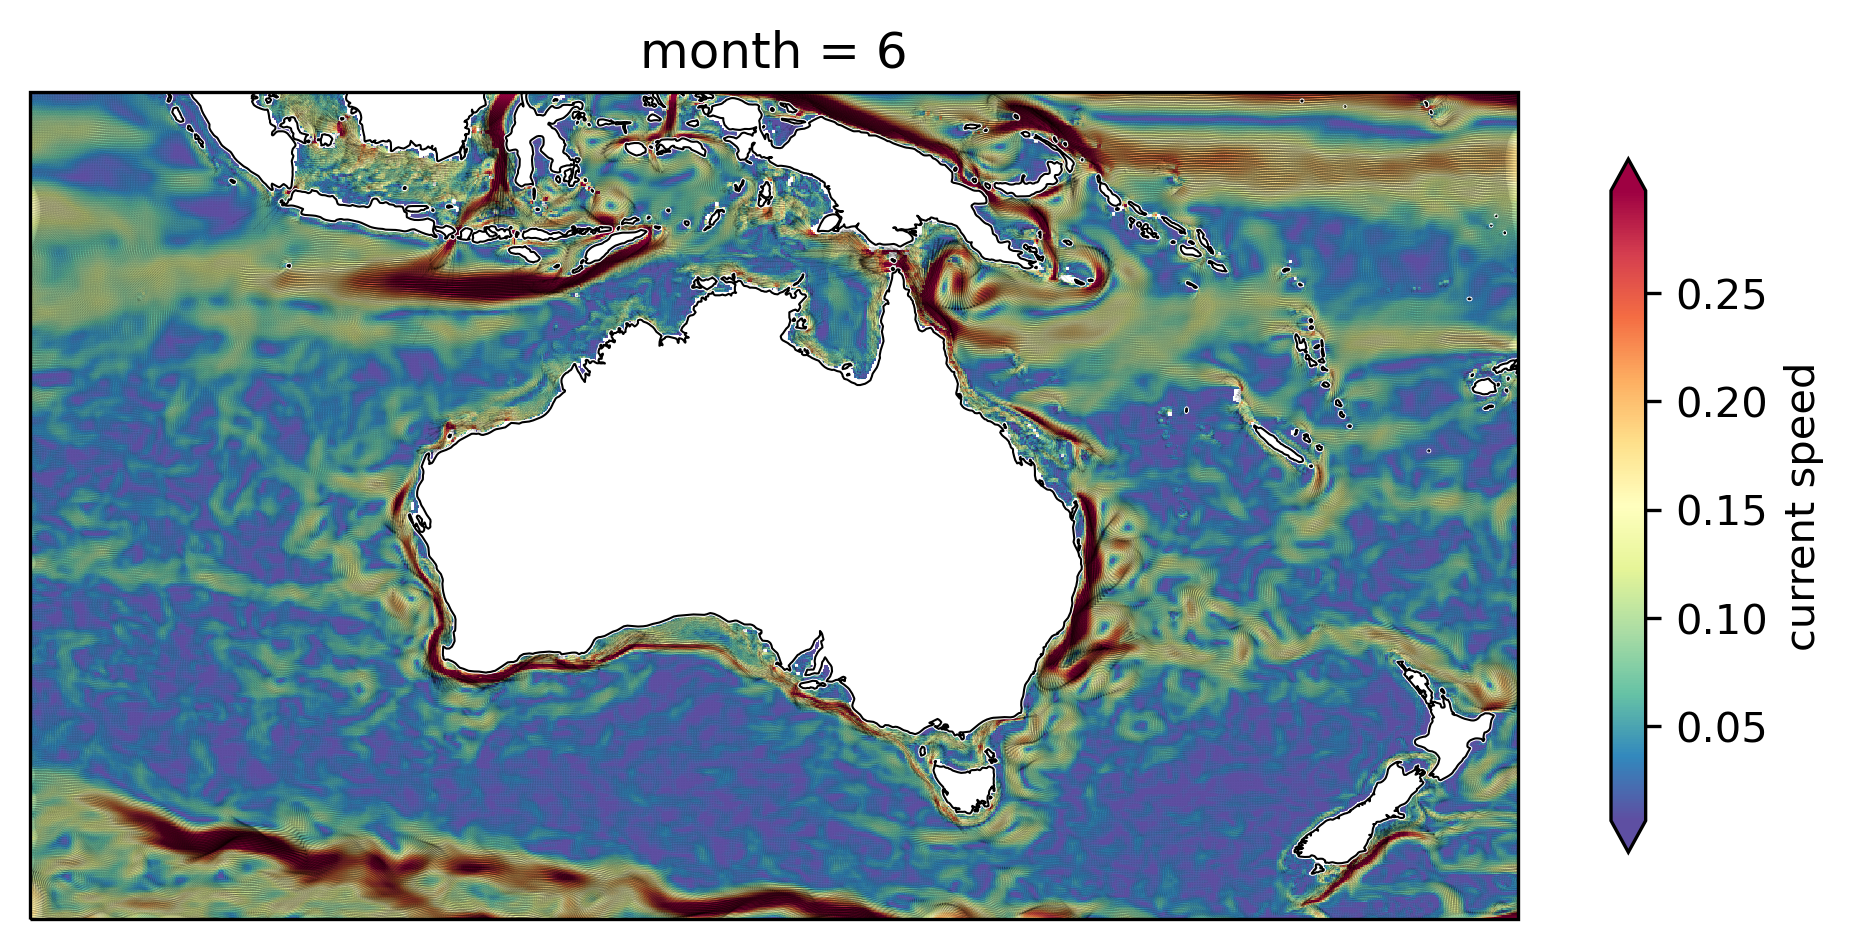

In [17]:
#plot model data
time_chosen = str(month_choice)
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([90,180, -50, -0], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.025, scale=.2, headwidth=5,alpha=0.2)



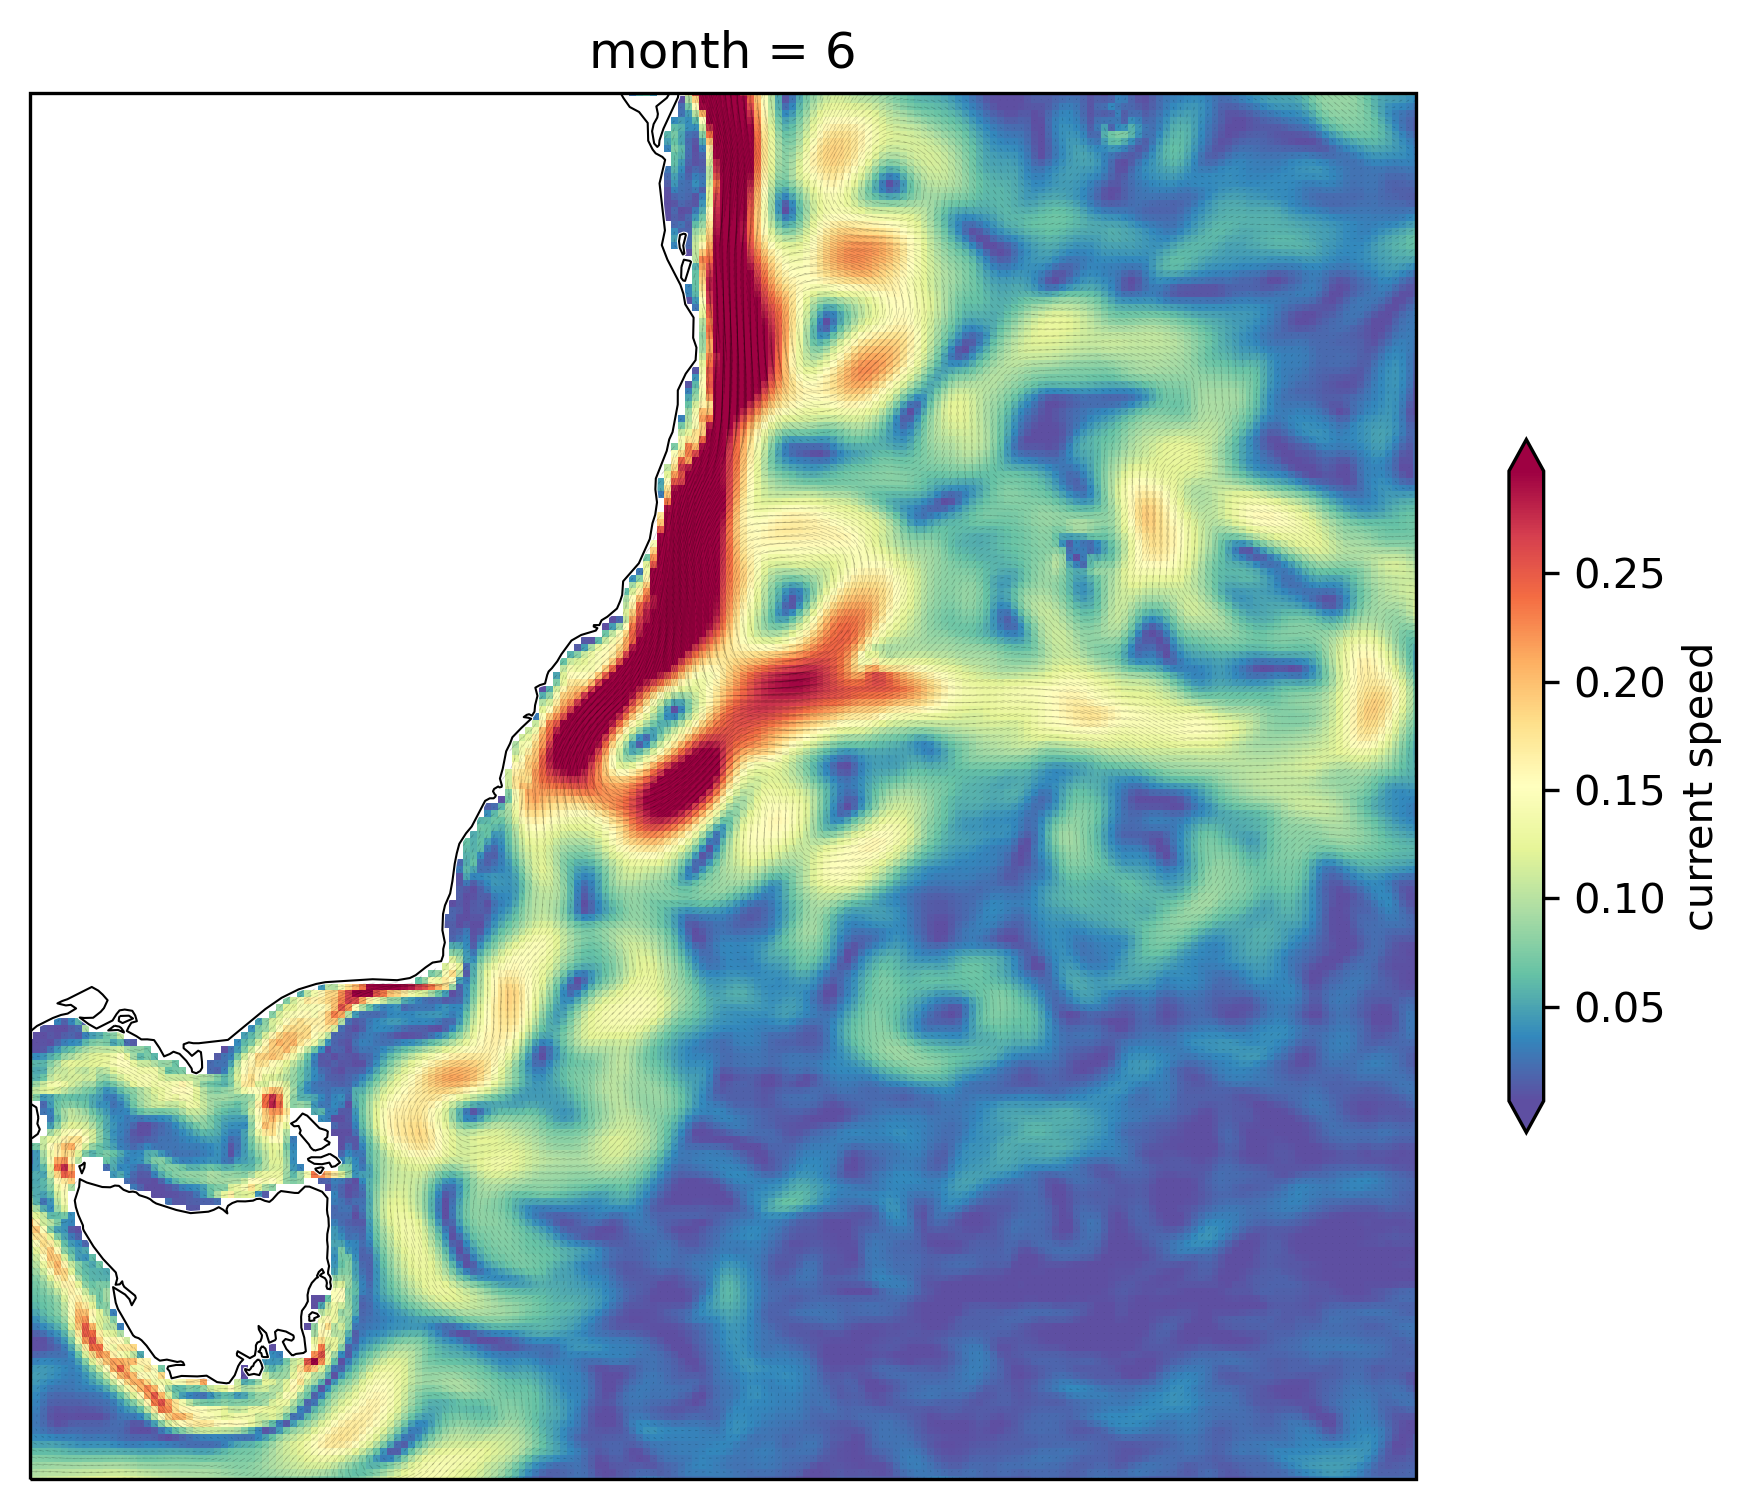

In [18]:
#plot model data
time_chosen = str(month_choice)
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([144,164, -45, -25], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)


Text(0.5, 1.0, 'BRAN2020 current climatology\n month 6')

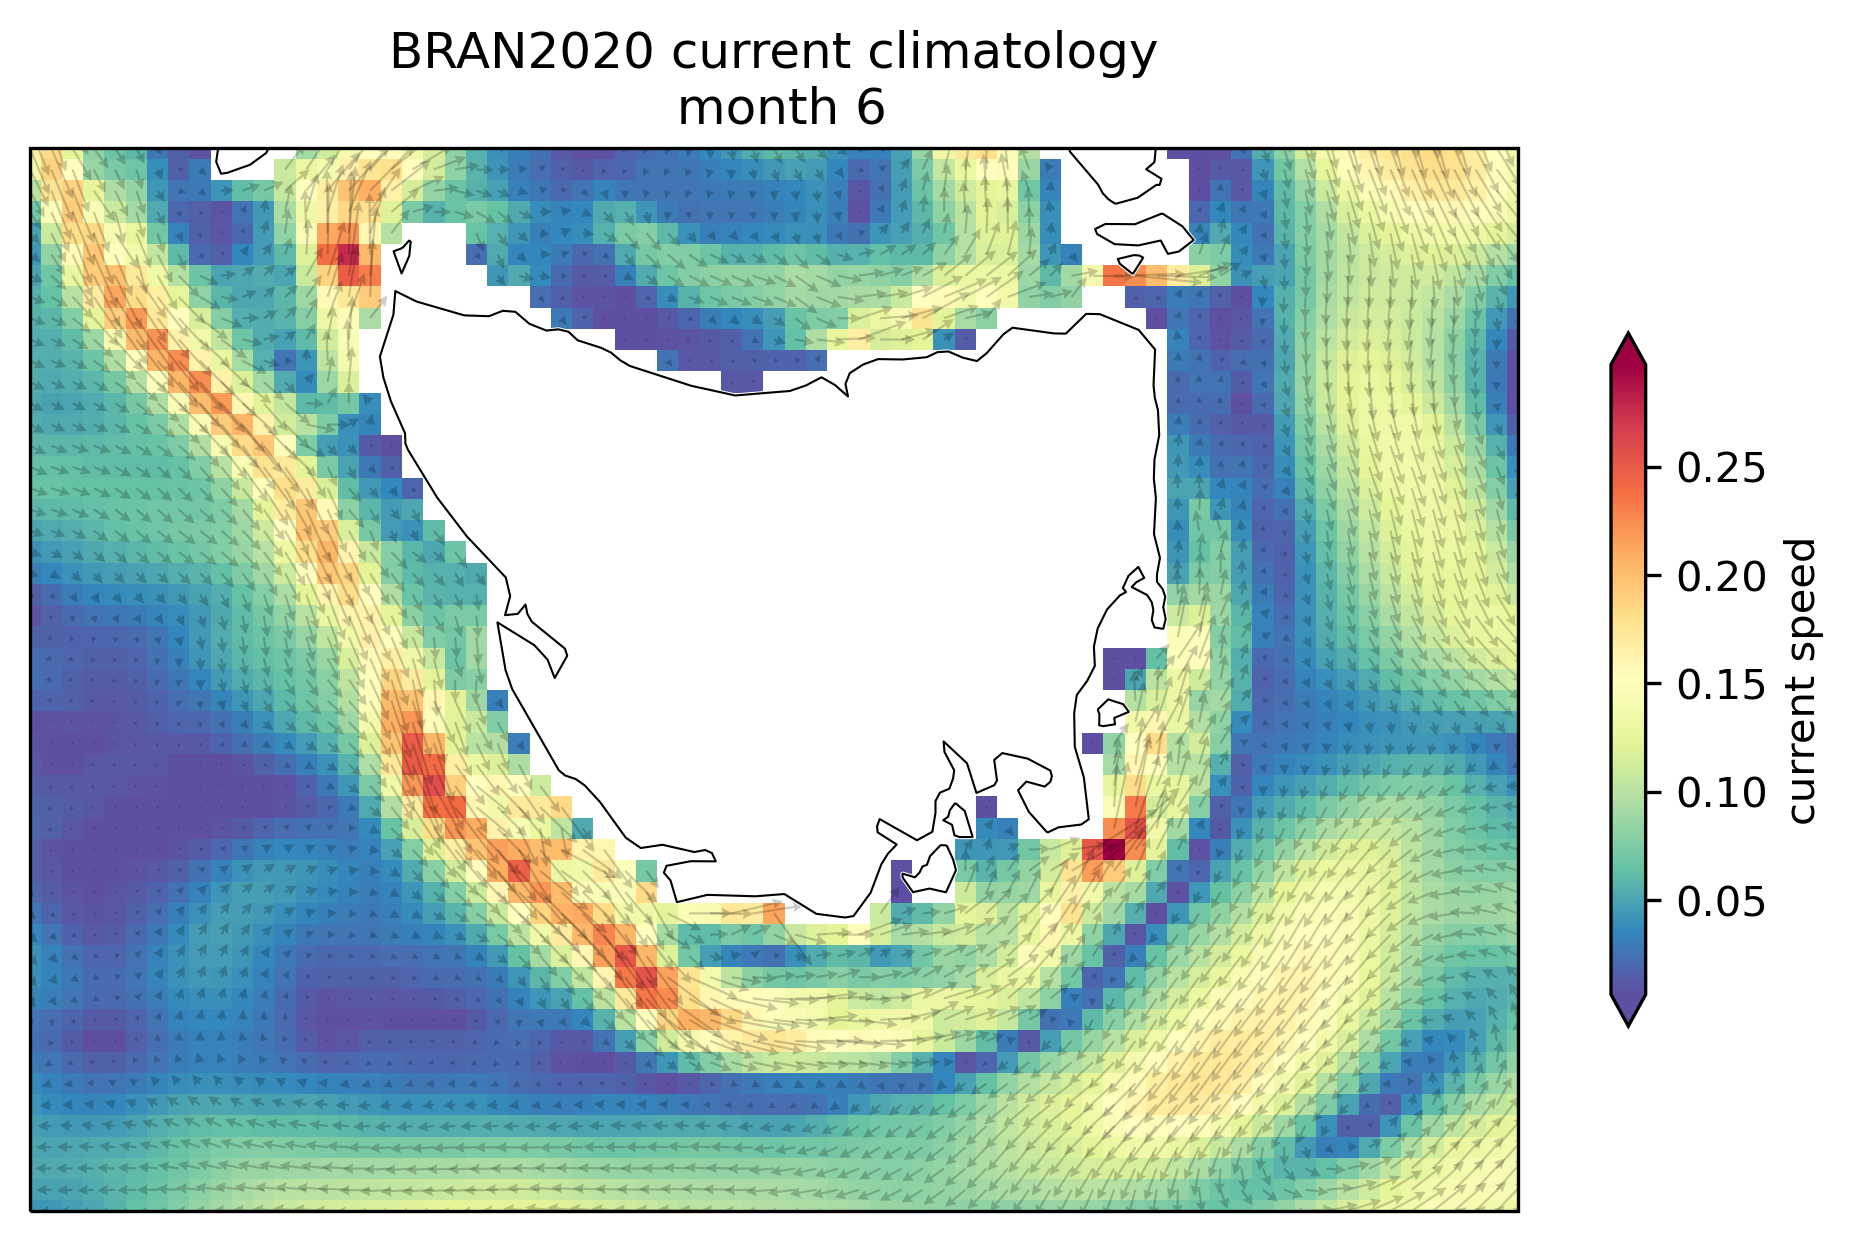

In [19]:
#plot model data
time_chosen = str(month_choice)
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([143,150, -45, -40], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=5,alpha=0.2)
plt.title('BRAN2020 current climatology\n month '+time_chosen)

# write clim UV to `zarr` 

In [10]:
clim_uv

<xarray.Dataset>
Dimensions:   (month: 12, st_ocean: 51, yu_ocean: 500, xu_ocean: 901)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xu_ocean  (xu_ocean) float64 90.0 90.1 90.2 90.3 ... 179.7 179.8 179.9 180.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... -0.4 -0.3 -0.2 -0.1
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u         (month, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 1, 500, 901), meta=np.ndarray>
    v         (month, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 1, 500, 901), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean Time: mean
    long_name:      i-current
    packing:        4
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-32767, 32767]

In [11]:
%%time
clim_uv.to_zarr('/scratch/xv83/tm4888/zarr_collections/BRAN2020/AUSregion.BRAN2020.climatology.UV.zarr',consolidated=True)

2023-06-15 13:34:57,975 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:35715
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/clean_pangeo/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/clean_pangeo/lib/python3.11/site-packages/distributed/worker.py", line 2032, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/v14/tm4888/miniconda3/envs/clean_pangeo/lib/python3.11/site-packages/distributed/worker.py", line 2853, in get_data_from_worker
    response = await send_recv(
               ^^^^^^^^^^^^^^^^
  File "/g/data/v14/tm4

CPU times: user 1min 10s, sys: 21.2 s, total: 1min 31s
Wall time: 7min 1s


# load climatology from zarr

In [20]:
clim_currents =  xr.open_zarr('/scratch/xv83/tm4888/zarr_collections/BRAN2020/AUSregion.BRAN2020.climatology.UV.zarr',consolidated=True)

# write to NetCDF

In [21]:
%%time
clim_currents.to_netcdf('/scratch/xv83/tm4888/zarr_collections/BRAN2020/AUSregion.BRAN2020.climatology.UV.nc')

CPU times: user 2.37 s, sys: 450 ms, total: 2.82 s
Wall time: 7.56 s


In [14]:
clim_currents = clim_currents.compute()

In [62]:
client.close()